In [70]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import warnings
import gffutils
from tqdm import tqdm

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
score_dir = '/data/leslie/suny4/predictions/tads/'
ct = 'mycGCB_am_gfp_myc_gcb_thelp_sample'
chrom = 1
osp.join(pred_dir, ct), osp.join(score_dir, ct)

('/data/leslie/suny4/predictions/chromafold/mycGCB_am_gfp_myc_gcb_thelp_sample',
 '/data/leslie/suny4/predictions/tads/mycGCB_am_gfp_myc_gcb_thelp_sample')

In [3]:
def load_preds_test(pred_dir, ct, chrom, avg_stripe=False):
    file = osp.join(pred_dir, ct,'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    pred_len, chrom_len = 200, temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array(
        [np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)]
    )
    summed = np.vstack(
        (np.zeros((pred_len, mat.shape[1])), mat)
    ).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack(
            (np.zeros((pred_len, mat.shape[1])), mat)
        )[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]

In [4]:
%%time
pred_mat = load_preds_test(pred_dir, ct, chrom, avg_stripe=True)

CPU times: user 6.69 s, sys: 3.91 s, total: 10.6 s
Wall time: 10.7 s


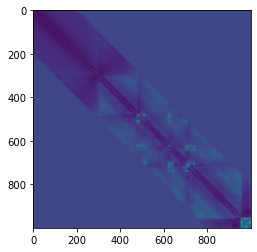

In [5]:
plt.imshow(pred_mat[:1000,:1000])
plt.show()

In [6]:
def binSignal(pred_mat, window_size=10):
    pad_mat = np.pad(pred_mat, window_size, mode='constant', constant_values=np.nan)
    dim = pad_mat.shape[0]
    signal = np.array([
        np.nanmean(pad_mat[i-window_size:i, i:i+window_size]) for i in range(dim)
    ][window_size+1: -window_size])
    
    return signal

In [60]:
signal = binSignal(pred_mat)

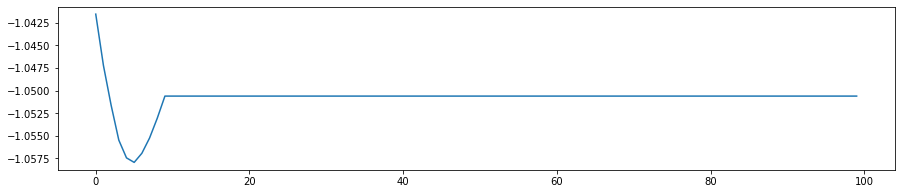

In [78]:
plt.figure(figsize=(15,3))
plt.plot(signal[:100])
plt.show()

In [73]:
fullsignal = np.tile(signal,(10000, 1)).flatten('F')

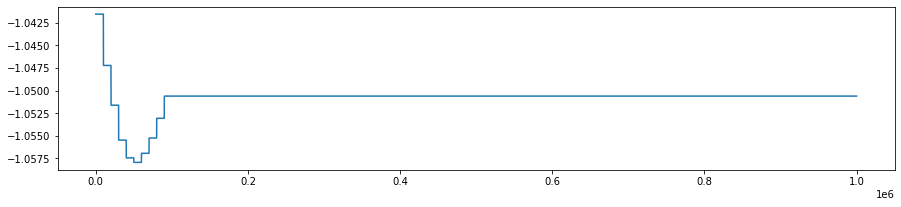

In [77]:
plt.figure(figsize=(15,3))
plt.plot(fullsignal[:100*10000])
plt.show()

In [105]:
l = len(signal)*10000
x = np.linspace(0, l, len(signal))
y = signal
xvals = np.linspace(0, l, l)
intersignal = np.interp(xvals, x, y)

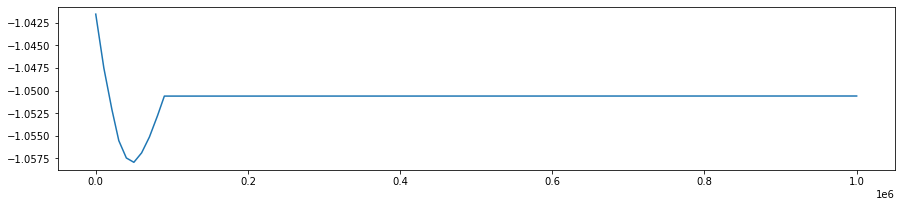

In [106]:
plt.figure(figsize=(15,3))
plt.plot(intersignal[:100*10000])
plt.show()

In [ ]:
def interpolate()

In [8]:
def signal_correlation(signal1, signal2, window_size=100):
    l = len(signal1) # raise len(signal1) != len(signal2)
    corr = []
    for i in range(l-window_size):
        temp1, temp2 = signal1[i:i+window_size], signal2[i:i+window_size]
        corr.append(scipy.stats.pearsonr(temp1, temp2)[0])
    return np.array(corr)

In [9]:
corr = signal_correlation(signal, signal)

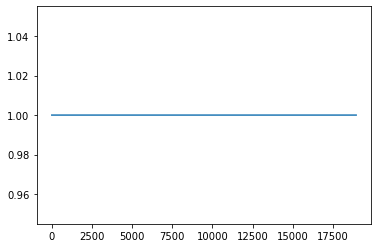

In [10]:
plt.plot(corr)
plt.show()

In [85]:
df = pd.read_csv('/data/leslie/suny4/data/chrom_size/gencode.vM10.basic.annotation.gtf',
                 sep='\t', comment='#', header=None)

In [86]:
df

,0,1,2,3,4,5,6,7,8
0,chr1,HAVANA,gene,3073253,3074322,.,+,.,"gene_id ""ENSMUSG00000102693.1""; gene_type ""TEC..."
1,chr1,HAVANA,transcript,3073253,3074322,.,+,.,"gene_id ""ENSMUSG00000102693.1""; transcript_id ..."
2,chr1,HAVANA,exon,3073253,3074322,.,+,.,"gene_id ""ENSMUSG00000102693.1""; transcript_id ..."
3,chr1,ENSEMBL,gene,3102016,3102125,.,+,.,"gene_id ""ENSMUSG00000064842.1""; gene_type ""snR..."
4,chr1,ENSEMBL,transcript,3102016,3102125,.,+,.,"gene_id ""ENSMUSG00000064842.1""; transcript_id ..."
...,...,...,...,...,...,...,...,...,...
1152948,chrM,ENSEMBL,transcript,15289,15355,.,+,.,"gene_id ""ENSMUSG00000064371.1""; transcript_id ..."
1152949,chrM,ENSEMBL,exon,15289,15355,.,+,.,"gene_id ""ENSMUSG00000064371.1""; transcript_id ..."
1152950,chrM,ENSEMBL,gene,15356,15422,.,-,.,"gene_id ""ENSMUSG00000064372.1""; gene_type ""Mt_..."
1152951,chrM,ENSEMBL,transcript,15356,15422,.,-,.,"gene_id ""ENSMUSG00000064372.1""; transcript_id ..."


In [11]:
gtf_file = '/data/leslie/suny4/data/chrom_size/gencode.vM10.basic.annotation.gtf'
db_file = '/data/leslie/suny4/data/chrom_size/gencode.vM10.basic.annotation.db'

In [43]:
def load_database(db_file, gtf_file):
    if osp.isfile(db_file):
        db = gffutils.FeatureDB(db_file)
    else:
        db = gffutils.create_db(gtf_file, db_file)
    
    return db

In [44]:
db = load_database(db_file, gtf_file)

In [59]:
print(db.schema())

CREATE TABLE features (
    id text,
    seqid text,
    source text,
    featuretype text,
    start int,
    end int,
    score text,
    strand text,
    frame text,
    attributes text,
    extra text,
    bin int,
    primary key (id)
    )
CREATE TABLE relations (
    parent text,
    child text,
    level int,
    primary key (parent, child, level)
    )
CREATE TABLE meta (
    dialect text,
    version text
    )
CREATE TABLE directives (
    directive text
    )
CREATE TABLE autoincrements (
    base text,
    n int,
    primary key (base)
    )
CREATE TABLE duplicates (
    idspecid text,
    newid text,
    primary key (newid)
    )
CREATE INDEX relationsparent ON relations (parent)
CREATE INDEX relationschild ON relations (child)
CREATE INDEX featuretype ON features (featuretype)
CREATE INDEX seqidstartend ON features (seqid, start, end)
CREATE INDEX seqidstartendstrand ON features (seqid, start, end, strand)
CREATE TABLE sqlite_stat1(tbl,idx,stat)


In [49]:
cur = db.execute('select * from features')

In [56]:
cur.fetchone().keys()

['id',
 'seqid',
 'source',
 'featuretype',
 'start',
 'end',
 'score',
 'strand',
 'frame',
 'attributes',
 'extra',
 'bin']

In [58]:
cur.fetchone()['start']

3214482